In [1]:
import tqdm
import random
import pathlib
import itertools
import collections

import os
import cv2
import numpy as np

import tensorflow as tf

# Some modules to display an animation using imageio.
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('TkAgg')

import keras
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [3]:
# Import the MoViNet model from TensorFlow Models (tf-models-official) for the MoViNet model
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model

In [4]:
def format_frames(frame, output_size):
    """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
    """
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize_with_pad(frame, *output_size)
    return frame

In [5]:
def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 5):
    """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
    """
    # Read each video frame by frame
    result = []
    src = cv2.VideoCapture(str(video_path))  

    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

    need_length = 1 + (n_frames - 1) * frame_step

    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start + 1)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    # ret is a boolean indicating whether read was successful, frame is the image itself
    ret, frame = src.read()
    result.append(format_frames(frame, output_size))

    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            frame = format_frames(frame, output_size)
            result.append(frame)
        else:
            result.append(np.zeros_like(result[0]))
    src.release()
    result = np.array(result)[..., [2, 1, 0]]

    return result

In [6]:
video_path = "/Users/nitu/Downloads/archive (1)/badminton_strokes_dataset/train/backhand_drive/bh_drive0.avi"

sample_video = frames_from_video_file(video_path, n_frames = 30)
sample_video.shape

def to_gif(images):
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('./animation.gif', converted_images)
    return embed.embed_file('./animation.gif')

In [7]:
class FrameGenerator:
    def __init__(self, path, n_frames, training = False):
        """ Returns a set of frames with their associated label. 

          Args:
            path: Video file paths.
            n_frames: Number of frames. 
            training: Boolean to determine if training dataset is being created.
        """
        self.path = path
        self.n_frames = n_frames
        self.training = training
        self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
        self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

    def get_files_and_class_names(self):
        video_paths = list(self.path.glob('*/*.avi'))
        classes = [p.parent.name for p in video_paths] 
        return video_paths, classes

    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()

        pairs = list(zip(video_paths, classes))

        if self.training:
            random.shuffle(pairs)

        for path, name in pairs:
            video_frames = frames_from_video_file(path, self.n_frames) 
            label = self.class_ids_for_name[name] # Encode labels
            yield video_frames[5:15], label

In [8]:
from pathlib import Path

In [9]:
path = Path('/Users/nitu/Downloads/archive (1)/badminton_strokes_dataset/train')
class_names = sorted(set(p.name for p in path.iterdir() if p.is_dir()))

In [10]:
path1 = Path('/Users/nitu/Downloads/archive (1)/badminton_strokes_dataset/validation')

path2 = Path('/Users/nitu/Downloads/archive (1)/badminton_strokes_dataset/test')

subset_paths = {'train' : path,
                'val' : path1,
                'test' : path2}

In [11]:
class_names

['backhand_drive',
 'backhand_net_shot',
 'forehand_clear',
 'forehand_drive',
 'forehand_lift',
 'forehand_net_shot']

In [12]:
class_ids_for_name = dict((name, idx) for idx, name in enumerate(class_names))

In [13]:
class_ids_for_name

{'backhand_drive': 0,
 'backhand_net_shot': 1,
 'forehand_clear': 2,
 'forehand_drive': 3,
 'forehand_lift': 4,
 'forehand_net_shot': 5}

In [14]:
subset_paths

{'train': PosixPath('/Users/nitu/Downloads/archive (1)/badminton_strokes_dataset/train'),
 'val': PosixPath('/Users/nitu/Downloads/archive (1)/badminton_strokes_dataset/validation'),
 'test': PosixPath('/Users/nitu/Downloads/archive (1)/badminton_strokes_dataset/test')}

In [15]:
fg = FrameGenerator(subset_paths['train'], 20, training=True)

frames, label = next(fg())

print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (10, 224, 224, 3)
Label: 5


In [16]:
frames, label = next(fg())

print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (10, 224, 224, 3)
Label: 5


In [17]:
batch_size = 8
num_frames = 20

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], num_frames, training = True),
                                          output_signature = output_signature)


test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], num_frames),
                                         output_signature = output_signature)


val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], num_frames),
                                         output_signature = output_signature)

In [18]:
merged_ds = train_ds.concatenate(test_ds)

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

merged_ds = merged_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [20]:
merged_ds = merged_ds.batch(batch_size)

In [21]:
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

In [22]:
val_ds = val_ds.batch(batch_size)

In [23]:
train_frames, train_labels = next(iter(merged_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

2023-10-11 13:32:22.515003: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 41 of 1000
2023-10-11 13:32:32.508181: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 85 of 1000
2023-10-11 13:32:42.756878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 131 of 1000
2023-10-11 13:32:52.761434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 173 of 1000
2023-10-11 13:33:02.658387: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 215 of 1000
2023-10-11 13:33:12.638258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 261 of 1000
2023-10-11 13:33:22.676950: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buf

Shape of training set of frames: (8, 10, 224, 224, 3)
Shape of training labels: (8,)


2023-10-11 13:34:58.512866: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 49 of 1000
2023-10-11 13:35:08.557635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 95 of 1000
2023-10-11 13:35:18.654749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 145 of 1000


Shape of validation set of frames: (8, 10, 224, 224, 3)
Shape of validation labels: (8,)


2023-10-11 13:35:22.599705: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


In [24]:
for frames, labels in merged_ds.take(10):
    print(labels)

tf.Tensor([2 4 0 4 1 4 4 0], shape=(8,), dtype=int16)
tf.Tensor([4 1 3 4 4 3 4 4], shape=(8,), dtype=int16)
tf.Tensor([2 2 4 2 3 1 3 1], shape=(8,), dtype=int16)
tf.Tensor([3 2 1 1 1 4 0 4], shape=(8,), dtype=int16)
tf.Tensor([5 3 1 4 5 0 2 1], shape=(8,), dtype=int16)
tf.Tensor([5 2 5 1 1 4 3 1], shape=(8,), dtype=int16)
tf.Tensor([5 1 4 5 4 3 1 5], shape=(8,), dtype=int16)
tf.Tensor([1 4 4 5 2 1 3 4], shape=(8,), dtype=int16)
tf.Tensor([1 4 4 3 3 2 2 5], shape=(8,), dtype=int16)
tf.Tensor([1 3 1 1 0 5 3 2], shape=(8,), dtype=int16)


In [25]:
print(f"Shape: {frames.shape}")
print(f"Label: {labels.shape}")

Shape: (8, 10, 224, 224, 3)
Label: (8,)


In [26]:
model_id = 'a0'
resolution = 224

tf.keras.backend.clear_session()

backbone = movinet.Movinet(model_id=model_id)
backbone.trainable = False

# Set num_classes=600 to load the pre-trained weights from the original model
model = movinet_model.MovinetClassifier(backbone=backbone, num_classes=600)
model.build([None, None, None, None, 3])

In [27]:
# Load pre-trained weights
#!wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a0_base.tar.gz -O movinet_a0_base.tar.gz -q
#!tar -xvf movinet_a0_base.tar.gz

checkpoint_dir = f'movinet_{model_id}_base'
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint = tf.train.Checkpoint(model=model)
status = checkpoint.restore(checkpoint_path)
status.assert_existing_objects_matched()

In [28]:
def build_classifier(batch_size, num_frames, resolution, backbone, num_classes):
    """Builds a classifier on top of a backbone model."""
    model = movinet_model.MovinetClassifier(backbone=backbone,num_classes=num_classes)
    model.build([batch_size, num_frames, resolution, resolution, 3])
    return model

In [29]:
model = build_classifier(batch_size, num_frames, resolution, backbone, 6)

In [30]:
num_epochs = 4

loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 0.001)

model.compile(loss=loss_obj, optimizer=optimizer, metrics=['accuracy'])

In [31]:
results = model.fit(merged_ds,
                    validation_data=val_ds,
                    epochs=num_epochs,
                    validation_freq=1,
                    verbose=1)

Epoch 1/4


2023-10-11 13:35:32.691696: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4061e2a20 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-10-11 13:35:32.691716: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-10-11 13:35:32.723065: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


      1/Unknown - 12s 12s/step - loss: 1.8119 - accuracy: 0.0000e+00

2023-10-11 13:35:38.824805: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


85/85 [==============================] - 605s 7s/step - loss: 1.6578 - accuracy: 0.2988 - val_loss: 1.5085 - val_accuracy: 0.3875
Epoch 2/4
85/85 [==============================] - 598s 7s/step - loss: 1.3415 - accuracy: 0.4630 - val_loss: 1.3594 - val_accuracy: 0.4500
Epoch 3/4
85/85 [==============================] - 597s 7s/step - loss: 1.1178 - accuracy: 0.5680 - val_loss: 1.2340 - val_accuracy: 0.5500
Epoch 4/4
85/85 [==============================] - 596s 7s/step - loss: 0.9738 - accuracy: 0.6317 - val_loss: 1.2066 - val_accuracy: 0.5688


In [32]:
results2 = model.fit(merged_ds,
                    validation_data=val_ds,
                    epochs= 2,
                    validation_freq=1,
                    verbose=1)

Epoch 1/2
85/85 [==============================] - 597s 7s/step - loss: 0.9075 - accuracy: 0.6494 - val_loss: 1.2616 - val_accuracy: 0.5063
Epoch 2/2
85/85 [==============================] - 600s 7s/step - loss: 0.8327 - accuracy: 0.6953 - val_loss: 1.3573 - val_accuracy: 0.5625


In [33]:
def get_actual_predicted_labels(dataset):
    """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
    """
    actual = [labels for _, labels in dataset.unbatch()]
    predicted = model.predict(dataset)

    actual = tf.stack(actual, axis=0)
    predicted = tf.concat(predicted, axis=0)
    predicted = tf.argmax(predicted, axis=1)

    return actual, predicted

In [34]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
    cm = tf.math.confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, annot=True, fmt='g')
    sns.set(rc={'figure.figsize':(12, 12)})
    sns.set(font_scale=1.4)
    ax.set_title('Confusion matrix of action recognition for ' + ds_type)
    ax.set_xlabel('Predicted Action')
    ax.set_ylabel('Actual Action')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.show()

In [35]:
fg = FrameGenerator(subset_paths['train'], num_frames, training = True)
label_names = list(fg.class_ids_for_name.keys())

In [ ]:
actual, predicted = get_actual_predicted_labels(merged_ds)

plot_confusion_matrix(actual, predicted, label_names, 'full_dataset')

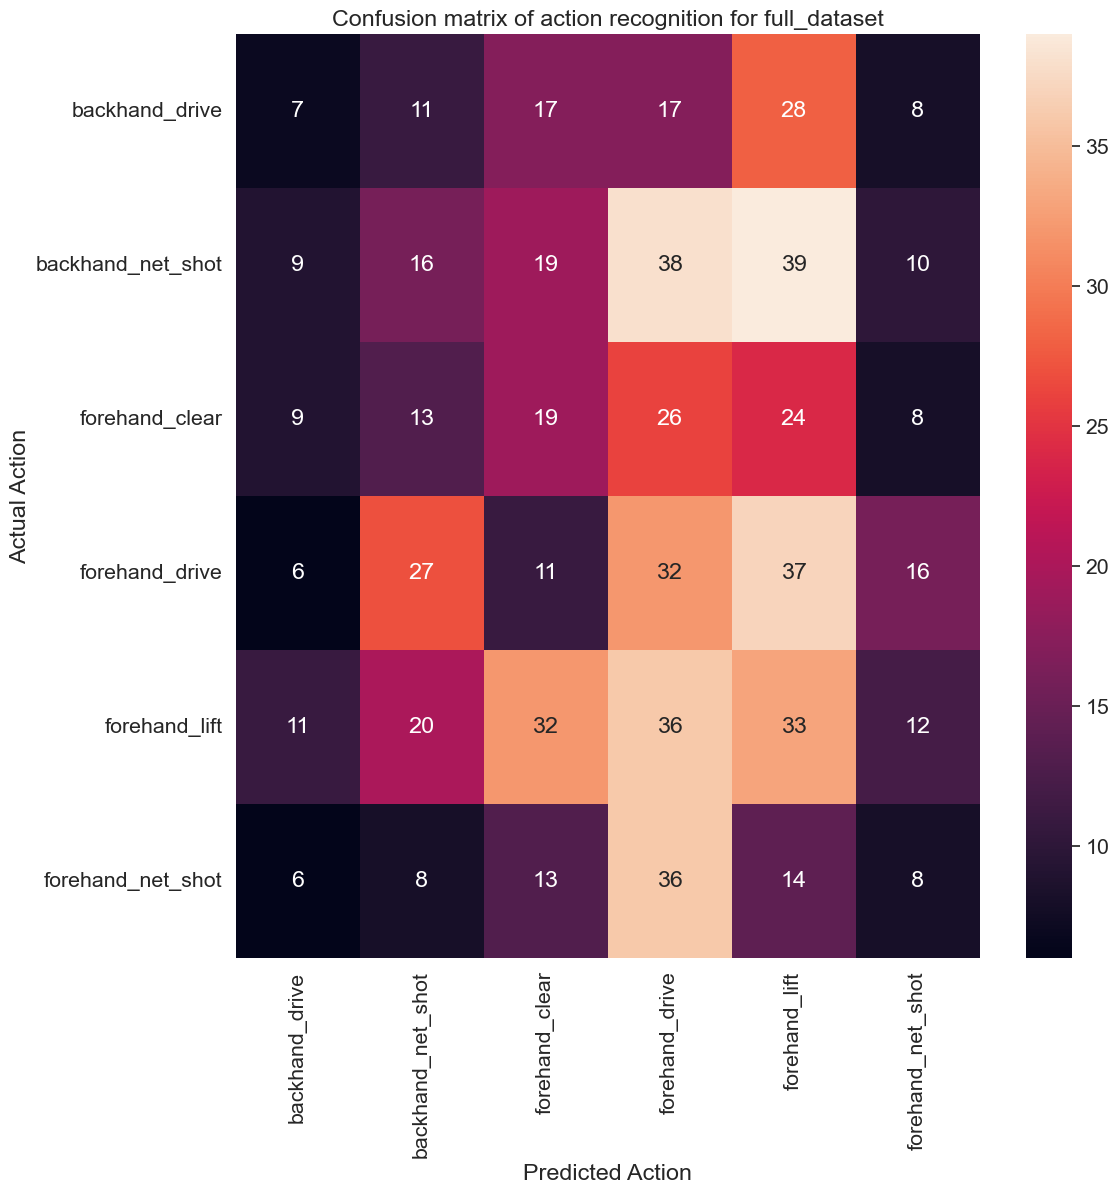